# CYPLAN255
### Urban Informatics and Visualization

# Lecture 13 -- APIs and Beyond <img src="https://i.imgur.com/HMHNjAq.jpg" width=550 align='right' title="Scottish child actress, Binkie Stuart (1932 - 2001) hand in hand with a penguin during a visit to London Zoo, 15th April 1937. (Photo by Fox Photos/Hulton Archive/Getty Images)">
******
March 11, 2024

# Agenda
1. Announcements
2. Review: APIs + JSON
2. Geocoding APIs
3. The Census API
4. Summary
5. For next time
6. Questions


# 1. Announcements

- Assignment 4 (project proposal + initial analysis) due March 10
- Final Project description released tonight
- Meiqing's GitHub Pages tutorial posted on bCourses
- How far we've come

## How Far We've Come

1. ~Fundamentals of Programming~
1. ~Intro to Data Analysis in Python~
1. ~Intro to Data Visualization~
1. APIs + Open Data
1. Working with Geospatial Data
1. Visualizing Spatial Data
1. Statistical Analysis + Machine Learning


# 2. Review: APIs + JSON

So far we've seen how you can use an API to download data stored as a .json file in some static location. That's cool, but ultimately not that different from clicking a link and downloading a file to your desktop. It also presumes you know the URL you want ahead of time, and that you want to download the entire file.

Today we're going to be seeing how you can use APIs to interact with _services_, i.e. APIs that perform operations and generate the data you want on demand. To continue with the restaurant analogy, we started off ordering fast food burgers, but now we're ready for the tasting menu at Chez Panisse.

<img src="https://i.kym-cdn.com/photos/images/original/001/474/943/b12.jpg" width=400>

But before we get there, let's quickly review what we've learned so far by checking out the USGS real-time earthquake data API.

### 2.1. USGS real-time earthquake feeds

This is an API for near-real-time data about earthquakes. Data is provided in JSON format over the web. No authentication is needed, and there's no way to customize the output. Instead, the API has a separate endpoint for each permutation of the data that users might want.

**API documentation:**  
http://earthquake.usgs.gov/earthquakes/feed/v1.0/geojson.php

**Sample API endpoint, for magnitude 4.5+ earthquakes in past day:**  
http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/4.5_day.geojson  


We'll start by querying the endpoint for magnitude 2.5+ quakes from the past week:

In [ ]:
import pandas as pd
import json    
import requests
import pprint
pp = pprint.PrettyPrinter

endpoint_url = "http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/2.5_week.geojson"
response = requests.get(endpoint_url)
print(response.text[:500])

It looks like the results are a string with JSON-formatted data inside, so we'll parse the string into a Python dictionary using `json.loads()`:

In [ ]:
data = json.loads(response.text)
data

Since JSON is just a dictionary, we can access subsets of the data can with square brackets, using labels for the named elements in a key-value pair, and numerals for positional indexing of list items.

Hint: whenever you see a file that ends in `.geojson`, you'll probably want to extract the data thats stored in the `features` dictionary:

In [ ]:
quakes = data['features']
quakes[0]

Because it is a nested dictionary at this point, we can use indexing into the dictionary to extract results.  Recall our earlier use of nested dictionaries? This is why we learned how to navigate nested dictionaries:

In [ ]:
for q in quakes:
    print(q['properties']['title'])

**SIDE BAR: GeoJSON?**

Working with geospatial data over the web, you will inevitably encounter called GeoJSON. GeoJSON is just JSON (which is just...???) with a slightly more well-defined schema to distinguish between metadata, spatial features, and classes of spatial features (e.g. points vs. lines vs. polygons).

There's lots of great tools out there for working with GeoJSON, but chief among them is [geojson.io](https://geojson.io). Try copying the first 5 entries from the quakes list into the `features` list on geojson.io and see what you find.

HINT: it's a little bit tricker to go from Python to JSON than from JSON to Python because Python doesn't care about single-quotes vs. double quotes, but JavaScript does. You can use the `json.dumps()` method to convert a Python dictionary to a valid JSON string.

In [ ]:
print(json.dumps(response.json()['features'][:5]))

Extracting data from nested dictionaries might be a good job for **list comprehension**:

In [ ]:
d = {
    'magnitude': [q['properties']['mag'] for q in quakes],
    'depth': [q['geometry']['coordinates'][2] for q in quakes]
}
df = pd.DataFrame.from_dict(d)

df.head()

In [ ]:
print(df.describe())

In [ ]:
df.plot(x='magnitude', y='depth', kind='scatter')

# 3. Geocoding

Now on to the main course: geocoding APIs.

## 3.1. What is geocoding?

**Geocoding** describes the process of converting place names and addresses to geographic coordinates (e.g. lat/lon).

<center><img src="https://dmpublisher.s3-us-west-2.amazonaws.com/old-dm/directionsmag.com/ee/images/newsletter/2004/10_20/EDramowicz_Figure1_lg.gif"></center>

Reverse geocoding is just the opposite process: using geographic coordinates to extract meaningful place names/addresses.

Perhaps this sounds like a dull topic, but **geocoding is a fundamental tool for anyone wishing to do spatial data analysis**.

Why? 

- 9 times out of 10, your data will have _either_ geographic coordinates _or_ administrative boundary names, but not both!
- 9 times out of 10 you will want to use additional data sources for which the above statement also applies
- Geocoding allows you to translate between the two (e.g. merging Census data into Craiglist rental listings)


## 3.2 Geocoding with the Mapbox API

Services like Google Maps and Mapbox have various APIs that let you access its services through code instead of through GUI apps. This one from Mapbox lets you look up the latitude-longitude coordinates of street addresses. You'll need to create a Mapbox API token in order to use this API, which you can do by following the instructions [here ](https://www.mapbox.com/signin/?route-to=%22/account/access-tokens%22) if you have not alread done so.


The Mapbox API queries work just like the ones we've already seen, but now we're including our own query parameters in the URL endpoint!

**API documentation:**  
https://www.mapbox.com/api-documentation/#geocoding

**API endpoint:**  
https://api.mapbox.com/geocoding/v5/mapbox.places

**API endpoint with query parameters:**  
https://api.mapbox.com/geocoding/v5/mapbox.places/Wurster+Hall.json?access_token=pk.eyJ1IjoiY3AyNTVkZW1vIiwiYSI6ImRPcTlnTUEifQ.3C0d0Nk_rcwV-8JF29PU-w

### 3.2.1. A word about API keys, tokens, and passwords in general

It's never a good idea to print an API key in a public document, including a script or notebook like this one. Particularly when you're using Git, deleting private data after you've already committed the change won't remove the data from your project history!

Instead, its good practice to create a small .json file which you can read into Python without ever having to print its contents. In this case, let's use a text editor to create a file named **mapbox_api_key.json** and put it in the `data/` directory. It's contents should look like this:

```javascript
{"key":"pk.eyJ1IjoidGFibGVkdWRlIiwiYSI6ImNsaGpmYmNhNjBoYTMzZm10aXl3OGtuZGcifQ.Rzi4EhaiUCLWCqCUq-CpCQ"}
```

Now we can read the API key from disk:

In [ ]:
import json

with open("data/mapbox_api_key.json", 'r') as f:
    key_file = f.read()
    
my_api_key = json.loads(key_file)['key']

### 3.2.2. Constructing an API query
Now we're ready to format our API request. 

In [ ]:
import requests

base_url = 'https://api.mapbox.com/geocoding/v5/mapbox.places/'
address = 'Goldman School of Public Policy'
params = {
    'limit': 1,  # just get the first record
    'access_token': my_api_key}

url = requests.Request('GET', base_url + address + '.json', params=params).prepare().url

This looks a little more complicated than what we saw last class. The main reason for this is that we are now doing more than simply submitting a `GET` request to URL whose full endpoint we know in advance. Instead, we just know the base URL of our API, and are using strings and key-value pairs to format the rest of the endpoint. This is pretty straightforward with one exception: HTTP doesn't know how to handle white space `" "` and many other special characters. So we are relying on the `Request.prepare()` method to take our input data and format it into a string that can be understood by HTTP.

You can try printing the url in the cell below to see what this formatted version of the URL looks like, but be careful because it will contain your API key!

In [ ]:
print(url)

### 3.2.3. Making the request and parsing the response

In [ ]:
from pprint import PrettyPrinter as pp
response = requests.get(url)
results = response.text
data = json.loads(results)
data

Does anyone think they have what it takes to extract the coordinates from our API response data?

In [ ]:
data['features'][0]['center']

### 3.2.5 Exercises

1. Search for some other addresses or landmarks!
2. Try storing your code as a function named `get_coords()` so that you need only supply a place name and your function will return the coordinates as list or tuple:
   ```python
    def get_coords(place_str):
        
        # do something with "place_str"
        
        return coords
        
   ```
2. Take a look at the [API documentation](https://www.mapbox.com/api-documentation/#geocoding). Can you figure out how to retrieve other points of interest near Wurster Hall?

In [ ]:
def get_coords(place_str):
    # do something with "place_str"
    base_url = 'https://api.mapbox.com/geocoding/v5/mapbox.places/'
    address = place_str
    params = {'limit': 1,  # just get the first record
              'access_token': my_api_key}
    url = requests.Request('GET', base_url + address + '.json', params=params).prepare().url
    response = requests.get(url)
    results = response.text
    data = json.loads(results)
    cords = data['features'][0]['center']
    return cords

In [ ]:
get_coords('Lick-Wilmerding')

### 3.2.4. The Mapbox SDK

Mapbox also maintans its own Python package which makes it a little easier to execute HTTP requests against its API. You can find the documentation [here](https://mapbox-mapbox.readthedocs-hosted.com/en/latest/index.html)

NOTE: the Mapbox Python API seems to be a bit buggy. In particular it doesn't seem to support Python > 3.9. If you encounter any issues trying to import modules from this library, the best thing to do is to roll back your Python version. From a terminal, you can do:

```bash
conda install python=3.9
```

and then restart your notebook kernel using the Kernel drop down menu in the menu panel above (or by typing `00` in rapid succession in command mode).

#### 3.2.4.1. Forward Geocoding

Forward geocoding is the one we have looked at so far using an API endpoint.  It takes an address or a place name and returns the geographic coordinates of that location.  Let's look at it again using the Mapbox Python SDK.

In [ ]:
from mapbox import Geocoder
import os

geocoder = Geocoder(access_token=my_api_key)

OK, now we can get to work on the geocoding... let's try geocoding Freehouse Restaurant, which is at 2700 Bancroft Way.

In [ ]:
response = geocoder.forward('2700 Bancroft Way, Berkeley, CA 94704', limit=1)
data = response.json()
data

Another random address to geocode:

In [ ]:
response = geocoder.forward('120 East 13th Street, Manhattan, New York, New York 10003', limit = 1)
first = response.json()['features'][0]
print(first['place_name'])
print([coord for coord in first['geometry']['coordinates']])

#### 3.2.4.2 Creating a dataframe from multiple API queries

Can you think of a good way to write a loop to geocode those addresses and add them to a dataframe?  Let's try one way to do this.

In [ ]:
import pandas as pd
data = pd.DataFrame(index=[], columns=['address','lat','lon'])

addrs = [
    '3028 Regent St., Berkeley, California, 94705',
    '1511 Julia St, Berkeley, California, 94703',
    '2700 Bancroft, Berkeley, California, 94704']

In [ ]:
for i in range(len(addrs)):
    geoadress=geocoder.forward(addrs[i], limit = 1).geojson()['features'][0]['geometry']['coordinates']
    data.loc[i, 'address']=addrs[i]
    data.loc[i, 'lon']=geoadress[0]
    data.loc[i, 'lat']=geoadress[1]
data

#### 3.2.4.3 Reverse Geocoding

Reverse geocoding does what it sounds like. It takes coordinates and returns an address or other place type.  Options for place type include: country, region, postcode, district, place, locality, neighborhood, address,and poi.

Let's start by using the coordinates of the address we just got from forward geocoding, and get the address back from reverse geocoding of those coordinates.

In [ ]:
response = geocoder.reverse(lat=37.868965, lon=-122.254267)
features = response.geojson()['features']
features

In [ ]:
for f in features:
    print('{place_type[0]}'.format(**f) + ':', '{place_name}'.format(**f))

## 3.3 Geocoding with Nominatim

Open source rules! Nominatim is an open source geocoding platform that is managed by OpenStreetMap (I think). Try using the Nominatim API to geocode or reverse geocode some data of interest! You can find the Nominamtim docs [here](https://nominatim.org/release-docs/develop/api/Search/)

Hint: whenever you're using an API for the first time, its always a good idea to start by trying to find some example queries in the documentation, and then tweaking them to meet your needs. 

In [ ]:
query_str = 'wurster hall'
url = "https://nominatim.openstreetmap.org/?addressdetails=1&q={0}&format=json&limit=1".format(query_str)
res = requests.get(url)

In [ ]:
res.json()

## 3.4. Reverse geocoding with the FCC API

Let's load the Craigslist rental listings again and quickly clean it up using the same code we previously used:

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('data/bay.csv')

# clean price and neighborhood
df.price = df.price.str.strip('$').astype('float64')
df.neighborhood = df.neighborhood.str.strip().str.strip('(').str.strip(')')

# break out the date into month day year columns
df['month'] = df['date'].str.split().str[0]
df['day'] = df['date'].str.split().str[1].astype('int32')
df['year'] = df['date'].str.split().str[2].astype('int32')
del df['date']

# extract bedrooms and square footage
def clean_bdrm(value):

    if isinstance(value, str):
        end = value.find('br')

        if end == -1:
            return
        
        else:
            start = value.find('/') + 2
            return int(value[start:end])

    else:
        return
    
def clean_sqft(value):

    if isinstance(value, str):
        end = value.find('ft')
        
        if end == -1:
            return

        else:
            if value.find('br') == -1:
                start = value.find('/') + 2
            else:
                start = value.find('-') + 2

            return int(value[start:end])

    else:
        return
    
df['sqft'] = df['beds_sqft'].map(clean_sqft)
df['bedrooms'] = df['beds_sqft'].map(clean_bdrm)
df.head()

And now let's use the FCC [Census Block Conversions API](https://geo.fcc.gov/api/census/) to turn lat/long into a block FIPS code. FIPS codes contain from left to right: the location's 2-digit state code, 3-digit county code, 6-digit census tract code, and 4-digit census block code (the first digit of which is the census block group code). With a FIPS code in hand, you can easily merge your data against Census records. 

Here's a sample API query to get you started:

In [ ]:
lat = 37.761216
lon = -122.396965
url = 'https://geo.fcc.gov/api/census/block/find?latitude={0}&longitude={1}&format=json'.format(lat, lon)
response = requests.get(url)
data = response.json()
data

## 3.5. Exercise

Your job now is to write some Python code to get the FIPS code for every row in the Craigslist rental data, and store that FIPS code as a new column in the dataframe. You might consider using [`df.iterrows()`](http://pandas.pydata.org/pandas-docs/dev/generated/pandas.DataFrame.iterrows.html) to loop through each row of the dataframe one at a time, or if you're feeling fancy, you could define a function and use a vectorized approach (e.g. `df.apply()` or `df.map()`) to run the function on each row of your dataframe without any loops at all!

**CAUTION: PLEASE DO NOT RUN THIS IN CLASS!!!** If we are all doing this at the same time on the same internet connection, you might get our IP address blacklisted by querying the API too many times.

A few tips:
- Since the API is SLOW for processing a lot of records, and works one record at a time, test out your code using only a few records until you are positive you have it working correctly. It may take several minutes to grind through all the records. You might want to print the row you are processing...maybe every 10th row, to give you some sense of how it is progressing.
- Watch out for those missing lat-longs. You'll probably want to skip them since the API won't know what to do with them.
- Consider adding some conditional logic to handle failed HTTP requests. This will prevent you from having to start your iteration over every time your program encounters an error

# 4. The Census API

Whatever "Urban Informatics" is or isn't, more often than not you'll find it useful to refer to census data. In this course, we'll be looking at capital-C Census data, i.e. the US Census, if for no other reason than the fact that it is being taught at UC Berkeley which happens to be located in California which happens to be located in the United States. Also, US Census data rocks!

**Question**: Does anyone know of other countries that have good, publically available census data?

The US Census provides API endpoints for most of its public data. You can find a list of them, along with links to their documentation, [here](https://www.census.gov/data/developers/data-sets.html). 

You can use those endpoints to construct your own custom queries and get the data you want by sending HTTP requests to those URLs. For example, to get the total population from 2018 in Alameda County, you can do:

In [59]:
# define parameters of our API query
acs_var = 'B01001_001E'  # total pop
state = '06'  # CA
counties = ['001', '075']  # Alameda and SF
year = 2018

# format the URL
counties_str = ','.join(counties)
url = "https://api.census.gov/data/{0}/acs/acs5?get={1}&for=county:{2}&in=state:{3}".format(
    year, acs_var, counties_str, state)
url
# execute the HTTP request
#res = requests.get(url)
#pd.DataFrame(res.json())

'https://api.census.gov/data/2018/acs/acs5?get=B01001_001E&for=county:001,075&in=state:06'

## 4.1. Getting a Census API key
A word of warning. These Census API queries may or may not work for you without specifying an API key. It's probably a good idea to get one anyways, because you will eventually be asked for it after enough queries. You can do that [here](https://api.census.gov/data/key_signup.html)

## 4.2. Census API Python Library

One of the great things about working with open source software and open data is that people are publishing useful tools all the time that you can use to make your life easier. In the case of Census data, there are multiple Python libraries to choose from which are designed to make it a little easier to interact with the Census API.

We'll focus on one that's simply called [census](https://github.com/datamade/census). You _will_ need a Census API key to use this package.

Use the instructions on that GitHub repo to use `pip` to install the `census` package, along with its sister package `us`.

In [56]:
from census import Census
from us import states

# I store my API key stored as an environment variable rather than a .json file
census_key = os.getenv("CENSUS_API")  

c = Census(census_key, year=year)
res = c.acs5.get((
    'NAME', acs_var), {
    'for': 'county:{}'.format(counties_str),
    'in': 'state:{}'.format(states.CA.fips)
})

pd.DataFrame(res)

,NAME,B01001_001E,state,county
0,"Alameda County, California",1629615.0,06,001
1,"San Francisco County, California",864263.0,06,075


In [57]:
acs_df = pd.DataFrame()

for year in range(2010, 2018):
    c = Census(census_key, year=year)
    res = c.acs1.get((
        'NAME', acs_var), {
        'for': 'county:{}'.format(counties_str),
        'in': 'state:{}'.format(states.CA.fips)
    })

    year_df = pd.DataFrame(res)
    year_df['year'] = year
    acs_df = pd.concat((acs_df, year_df), ignore_index=True)

<Axes: xlabel='year', ylabel='B01001_001E'>

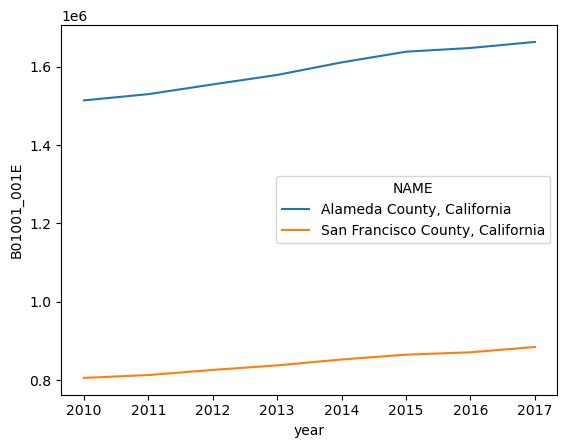

In [54]:
import seaborn as sns
sns.lineplot(data=acs_df, x='year', y=acs_var, hue='NAME')

## 4.3 More exercises!

Your turn: 
1. Look up the latitude and longitude of your home address using forward geocoding
2. Use the latitude and longitude from that to get the census block of your home address
3. Challenge problem: create a dataframe with 3 street addresses and a description column with labels for these locations, and write code that will iterate through them, get the latitude and longitude for each, and the FIPS block code, County name, and write these addresses, lat and long, and FIPS Block code and County names to a dataframe.

In [55]:
%%html
<iframe style="border-radius:12px" src="https://open.spotify.com/embed/track/4KBULZasCMBDKHY8IPUCML?utm_source=generator" width="40%" height="80" frameBorder="0" allowfullscreen="" allow="autoplay; clipboard-write; encrypted-media; fullscreen; picture-in-picture"></iframe>

# 5. Summary

By this point in the class you have all the tools you need to:
1. find interesting data sets
1. load them into Python
1. explore, clean, and manipulate that data
1. combine it with external administrative or demographic data from the Census
1. create charts and visualizations to communicate your findings
1. save your new data to disk so you can come back to it later

# 6. For next time

- We're about to enter my favorite module of this course: **Working with Geospatial Data**. Some of you have considerable experience with GIS already, and are very comfortable with concepts like coordinate reference systems and map projections, and how to deal with these when working with spatial data.  If so, you might not need to spend much time with the readings for next session, but if not, please at least familiarize yourself with the material from the first two links on the syllabus:
  - [mapschool.io](https://mapschool.io/)
  - Part I of [Geographic Data Science with Python](https://geographicdata.science/book/notebooks/00_toc.html)

- We will also be using the GeoPandas Python library, so browse the documentation [here](http://geopandas.org/) and install it ahead of time.
- Work through the exercises in this notebook that you didn't get through in class

# 7. Questions?

# Sources

This notebook was heavily adapted from previous course material by [Prof. Paul Waddell](https://urbansim.com/people) and [Samuel Maurer](http://samuelmaurer.info/).